In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np
import matplotlib.pyplot as plt
import os
import openpathsampling.visualize as ops_vis
from IPython.display import SVG

### Advanced analysis techniques

Now we'll move on to a few more advanced analysis techniques. (These are discussed in Paper II.)

With the fixed path length ensemble, we should check for recrossings. To do this, we create an ensemble which represents the recrossing paths: a frame in $\beta$, possible frames in neither $\alpha$ nor $\beta$, and then a frame in $\alpha$.

Then we check whether any subtrajectory of a trial trajectory matches that ensemble, by using the `Ensemble.split()` function. We can then further refine to see which steps that included trials with recrossings were actually accepted.

In [2]:
%%time
flexible = paths.AnalysisStorage("tps_nc_files/alanine_dipeptide_tps.nc")

CPU times: user 1min 40s, sys: 7.66 s, total: 1min 48s
Wall time: 6min 17s


In [3]:
%%time
fixed = paths.AnalysisStorage("tps_nc_files/alanine_dipeptide_fixed_tps.nc")

CPU times: user 3min 33s, sys: 2min 7s, total: 5min 41s
Wall time: 1h 24min 17s


In [4]:
flex_scheme = flexible.schemes[0]
fixed_scheme = fixed.schemes[0]

In [ ]:
# TODO: cache trajectories too?

In [5]:
# create the ensemble that identifies recrossings
alpha = fixed.volumes.find('C_7eq')
beta = fixed.volumes.find('alpha_R')
recrossing_ensemble = paths.SequentialEnsemble([
    paths.LengthEnsemble(1) & paths.AllInXEnsemble(beta),
    paths.OptionalEnsemble(paths.AllOutXEnsemble(alpha | beta)),
    paths.LengthEnsemble(1) & paths.AllInXEnsemble(alpha) 
])

In [6]:
%%time
# now we check each step to see if its trial has a recrossing
steps_with_recrossing = []
for step in fixed.steps:
    # trials is a list of samples: with shooting, only one in the list
    recrossings = [] # default for initial empty move (no trials in step[0].change)
    for trial in step.change.trials:
        recrossings = recrossing_ensemble.split(trial.trajectory)
        # recrossing contains a list with the recrossing trajectories
        # (len(recrossing) == 0 if no recrossings)
    if len(recrossings) > 0:
        steps_with_recrossing += [step]  # save for later analysis

In [7]:
accepted_recrossings = [step for step in steps_with_recrossing if step.change.accepted is True]

In [8]:
print "Trials with recrossings:", len(steps_with_recrossing)
print "Accepted trials with recrossings:", len(accepted_recrossings)

Trials with recrossings: 564
Accepted trials with recrossings: 103


Note that the accepted trials with recrossing does not account for how long the trial remained active. It also doesn't tell us whether the trial represented a new recrossing event, or was correlated with the previous recrossing event.

Let's take a look at one of the accepted trajectories with a recrossing event. We'll plot the value of $\psi$, since this is what distinguishes the two states. We'll also select the frames that are actually inside each state and color them (red for $\alpha$, blue for $\beta$).

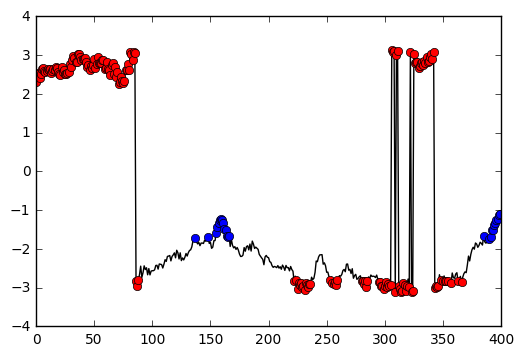

In [9]:
psi = fixed.cvs.find('psi')
trajectory = accepted_recrossings[0].active[0].trajectory
in_alpha_indices = [trajectory.index(s) for s in trajectory if alpha(s)]
in_alpha_psi = [psi(trajectory)[i] for i in in_alpha_indices]
in_beta_indices = [trajectory.index(s) for s in trajectory if beta(s)]
in_beta_psi = [psi(trajectory)[i] for i in in_beta_indices]

plt.plot(psi(trajectory), 'k-')
plt.plot(in_alpha_indices, in_alpha_psi, 'ro')  # alpha in red
plt.plot(in_beta_indices, in_beta_psi, 'bo')  # beta in blue

Now let's see how many recrossing events there are in each accepted trial. If there's one recrossing, then the trajectory much go $\alpha\to\beta\to\alpha\to\beta$ to be accepted. Two recrossings would mean $\alpha\to\beta\to\alpha\to\beta\to\alpha\to\beta$.

In [10]:
recrossings_per = []
for step in accepted_recrossings:
    for test in step.change.trials:
        recrossings_per.append(len(recrossing_ensemble.split(test.trajectory)))

In [11]:
print recrossings_per

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1]


# Comparing the fixed and flexible simulations

In [12]:
%%time
# transition path length distribution
flex_ens = flex_scheme.network.sampling_ensembles[0]
fixed_transition_segments = sum([flex_ens.split(step.active[0].trajectory) for step in fixed.steps],[])
fixed_transition_length = [len(traj) for traj in fixed_transition_segments]

CPU times: user 3h 18min 16s, sys: 1min 50s, total: 3h 20min 7s
Wall time: 3h 34min 16s


In [15]:
flexible_transition_length = [len(s.active[0].trajectory) for s in flexible.steps]

In [16]:
print len(fixed_transition_length)

10230


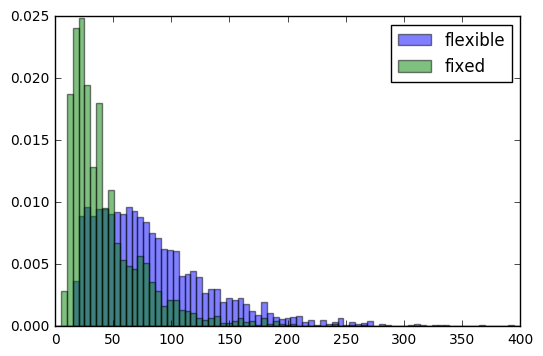

In [18]:
bins = np.linspace(0, 400, 80);
plt.hist(flexible_transition_length, bins, alpha=0.5, normed=True, label="flexible");
plt.hist(fixed_transition_length, bins, alpha=0.5, normed=True, label="fixed");
plt.legend(loc='upper right');

#### Identifying different mechanisms using custom ensembles

We expected the plot above to be very similar for both cases. However, we know that the $\alpha\to\beta$ transition in alanine dipeptide can occur via two mechanisms: since $\psi$ is periodic, the transition can occur due to an overall increase in $\psi$, or due to an overall decrease in $\psi$. We also know that the alanine dipeptide transitions aren't actually all that rare, so they will occur spontaneously in long simulations.


This section shows how to create custom ensembles to identify whether the transition occurred with an increasing $\psi$ or a decreasing $\psi$. We also need to account for (unlikely) edge cases where the path starts in one direction but completes the transition from the other.

First, we'll create a few more `Volume` objects. In this case, we will completely tile the Ramachandran space; while a complete tiling isn't necessary, it is often useful.

In [19]:
# first, we fully subdivide the Ramachandran space
phi = fixed.cvs.find('phi')
deg = 180.0/np.pi
nml_plus = paths.PeriodicCVDefinedVolume(psi, -160/deg, -100/deg, -np.pi, np.pi)
nml_minus = paths.PeriodicCVDefinedVolume(psi, 0/deg, 100/deg, -np.pi, np.pi)
nml_alpha = (paths.PeriodicCVDefinedVolume(phi, 0/deg, 180/deg, -np.pi, np.pi) &
             paths.PeriodicCVDefinedVolume(psi, 100/deg, 200/deg, -np.pi, np.pi))
nml_beta = (paths.PeriodicCVDefinedVolume(phi, 0/deg, 180/deg, -np.pi, np.pi) &
            paths.PeriodicCVDefinedVolume(psi, -100/deg, 0/deg, -np.pi, np.pi))

In [20]:
#TODO: plot to display where these volumes are

Next, we'll create ensembles for the "increasing" and "decreasing" transitions. These transitions mark a crossing of either the `nml_plus` or the `nml_minus`. These aren't necessarily $\alpha\to\beta$ transitions. However, any $\alpha\to\beta$ transition must contain at least one subtrajectory which satsifies one of these ensembles.

In [21]:
increasing = paths.SequentialEnsemble([
    paths.AllInXEnsemble(alpha | nml_alpha),
    paths.AllInXEnsemble(nml_plus),
    paths.AllInXEnsemble(beta | nml_beta)
])
decreasing = paths.SequentialEnsemble([
    paths.AllInXEnsemble(alpha | nml_alpha),
    paths.AllInXEnsemble(nml_minus),
    paths.AllInXEnsemble(beta | nml_beta)
])

Finally, we'll write a little function that characterizes a set of trajectories according to these ensembles. It returns a dictionary mapping the ensemble (`increasing` or `decreasing`) to a list of trajectories that have a subtrajectory that satisfies it (at least one entry in `ensemble.split(trajectory)`). That dictionary also contains keys for `'multiple'` matched ensembles and `None` if no ensemble was matched. Trajectories for either of these keys would need to be investigated further.

In [22]:
def categorize_transitions(ensembles, trajectories):
    results = {ens : [] for ens in ensembles + ['multiple', None]}
    for traj in trajectories:
        matched_ens = None
        for ens in ensembles:
            if len(ens.split(traj)) > 0:
                if matched_ens is not None:
                    matched_ens = 'multiple'
                else:
                    matched_ens = ens
        results[matched_ens].append(traj)
    return results

With that function defined, let's use it!

In [23]:
categorized = categorize_transitions(ensembles=[increasing, decreasing],
                                     trajectories=fixed_transition_segments)

In [24]:
print "increasing:", len(categorized[increasing])
print "decreasing:", len(categorized[decreasing])
print "  multiple:", len(categorized['multiple'])
print "      None:", len(categorized[None])

increasing: 7229
decreasing: 3001
  multiple: 0
      None: 0


Comparing to the flexible length simulation:

In [25]:
flex_trajs = [step.active[0].trajectory for step in flexible.steps]
flex_categorized = categorize_transitions(ensembles=[increasing, decreasing],
                                          trajectories=flex_trajs[::10])

In [26]:
print "increasing:", len(flex_categorized[increasing])
print "decreasing:", len(flex_categorized[decreasing])
print "  multiple:", len(flex_categorized['multiple'])
print "      None:", len(flex_categorized[None])

increasing: 0
decreasing: 1001
  multiple: 0
      None: 0


So the fixed length sampling is somehow capturing both kinds of transitions (probably because they are not really that rare). Let's see what the path length distribution from only the decreasing transitions looks

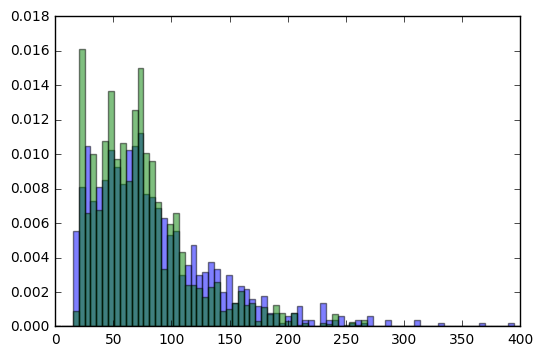

In [27]:
plt.hist([len(traj) for traj in flex_categorized[decreasing]], bins, alpha=0.5, normed=True);
plt.hist([len(traj) for traj in categorized[decreasing]], bins, alpha=0.5, normed=True);

Still a little off, although this might be due to bad sampling. Let's see how many of the decorrelated trajectories have this kind of transition.

In [29]:
full_fixed_tree = ops_vis.PathTree(
    fixed.steps,
    ops_vis.ReplicaEvolution(replica=0)
)
full_history = full_fixed_tree.generator

In [30]:
# start with the decorrelated tragectories
fixed_decorrelated = full_history.decorrelated_trajectories
# find the A->B transitions from the decorrelated trajectories
decorrelated_transitions = sum([flex_ens.split(traj) for traj in fixed_decorrelated], [])
# find the A->B transition from these which are decreasing
decorrelated_decreasing = sum([decreasing.split(traj) for traj in decorrelated_transitions], [])
print len(decorrelated_decreasing)

115


So this is based off of 11 decorrelated trajectory transitions. That's not a lot of statistics.

However, we expect to see a *very* different distribution for the "increasing" paths:

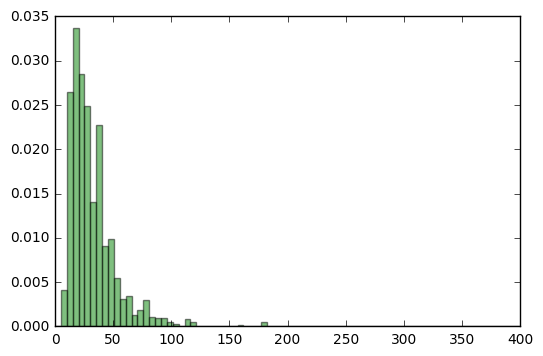

In [31]:
plt.hist([len(traj) for traj in categorized[increasing]], bins, normed=True, alpha=0.5, color='g');

Let's also check whether we go back and forth between the increasing transition and the decreasing transition, or whether there's just a single change from one type to the other.

In [32]:
def find_switches(ensembles, trajectories):
    switches = []
    last_category = None
    traj_num = 0
    for traj in trajectories:
        category = None
        for ens in ensembles:
            if len(ens.split(traj)) > 0:
                if category is not None:
                    category = 'multiple'
                else:
                    category = ens
        if last_category != category:
            switches.append((category, traj_num))
        traj_num += 1
        last_category = category
    return switches

In [33]:
switches = find_switches([increasing, decreasing], fixed_transition_segments)

In [34]:
print [switch[1] for switch in switches], len(fixed_transition_segments)

[0, 14, 406, 443, 458, 512, 669, 784, 972, 986, 1010, 1136, 1672, 1984, 1998, 2018, 2115, 2154, 2379, 2519, 2682, 2743, 2930, 3038, 3090, 3093, 3307, 3339, 3538, 3884, 3974, 3981, 4255, 4332, 4370, 4560, 4825, 4884, 4885, 4886, 4887, 4888, 4988, 4998, 5027, 5105, 5370, 5414, 5533, 5638, 5657, 5701, 5752, 5761, 6124, 6151, 6322, 6634, 7042, 7114, 7441, 7494, 7521, 7584, 7767, 7839, 7944, 7950, 8321, 8414, 8615, 8719, 9610, 9611, 9972, 10055, 10106, 10175] 10230


So there are a lot of switches early in the simulation, and then it gets stuck in one state for much longer.

Even though we know the alanine dipeptide transitions are not particularly rare, this does give us reason to re-check the temperature. First we'll check what the intergrator says its temperature is, then we'll calculate the temperature based on the kinetic energy of every 50th trajectory.

Note that the code below is specific to using the OpenMM engine.

In [48]:
every_50th_trajectory = [step.active[0].trajectory for step in fixed.steps[::50]]

In [49]:
# make a set to remove duplicates, if trajs aren't decorrelated
every_50th_traj_snapshots = list(set(sum(every_50th_trajectory, [])))
# sadly, it looks like that trick with set doesn't do any good here

In [50]:
# this is ugly as sin: we need a better way of doing it (ideally as a snapshot feature)

# dof calculation taken from OpenMM's StateDataReporter
import simtk.openmm as mm
import simtk.unit
dof = 0
system = engine.simulation.system
dofs_from_particles = 0
for i in range(system.getNumParticles()):
    if system.getParticleMass(i) > 0*simtk.unit.dalton:
        dofs_from_particles += 3
dofs_from_constraints = system.getNumConstraints()
dofs_from_motion_removers = 0
if any(type(system.getForce(i)) == mm.CMMotionRemover for i in range(system.getNumForces())):
    dofs_from_motion_removers += 3
dof = dofs_from_particles - dofs_from_constraints - dofs_from_motion_removers
#print dof, "=", dofs_from_particles, "-", dofs_from_constraints, "-", dofs_from_motion_removers

kinetic_energies = []
potential_energies = []
temperatures = []
R = simtk.unit.BOLTZMANN_CONSTANT_kB * simtk.unit.AVOGADRO_CONSTANT_NA
for snap in every_50th_traj_snapshots:
    engine.current_snapshot = snap
    state = engine.simulation.context.getState(getEnergy=True)
    ke = state.getKineticEnergy()
    temperatures.append(2 * ke / dof / R)

No handlers could be found for logger "openpathsampling.engines.dynamics_engine"


Mean temperature: 300.33 K


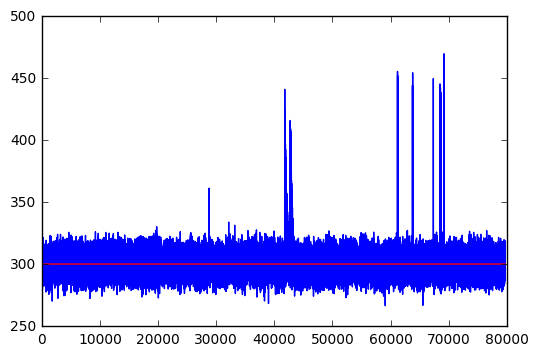

In [51]:
plt.plot([T / T.unit for T in temperatures])
mean_T = np.mean(temperatures)
plt.plot([mean_T / mean_T.unit]*len(temperatures), 'r')
print "Mean temperature:", np.mean(temperatures).format("%.2f")